In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms

/Users/dhk/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out = F.avg_pool2d(out4, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out, [out1, out2, out3, out4]

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

In [3]:
# Directory Setup
data_dir = "./dataset"
result_dir = "./results"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
''' organize the real dataset '''
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
dst_train = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform) # no augmentation
class_names = dst_train.classes

images_all = []
labels_all = []
indices_class = [[] for c in range(10)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

# Model
num_layer = 4
net = ResNet18(3, 10)
state_dict = torch.load("resnet18_cifar.pt", map_location='cpu')
net.load_state_dict(state_dict)
net = net.to(device)
net.eval()

Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

Gathering features for class airplane
Calculating cluster center features for class airplane
Gathering features for class automobile
Calculating cluster center features for class automobile
Gathering features for class bird
Calculating cluster center features for class bird
Gathering features for class cat
Calculating cluster center features for class cat
Gathering features for class deer
Calculating cluster center features for class deer
Gathering features for class dog
Calculating cluster center features for class dog
Gathering features for class frog
Calculating cluster center features for class frog
Gathering features for class horse
Calculating cluster center features for class horse
Gathering features for class ship
Calculating cluster center features for class ship
Gathering features for class truck
Calculating cluster center features for class truck


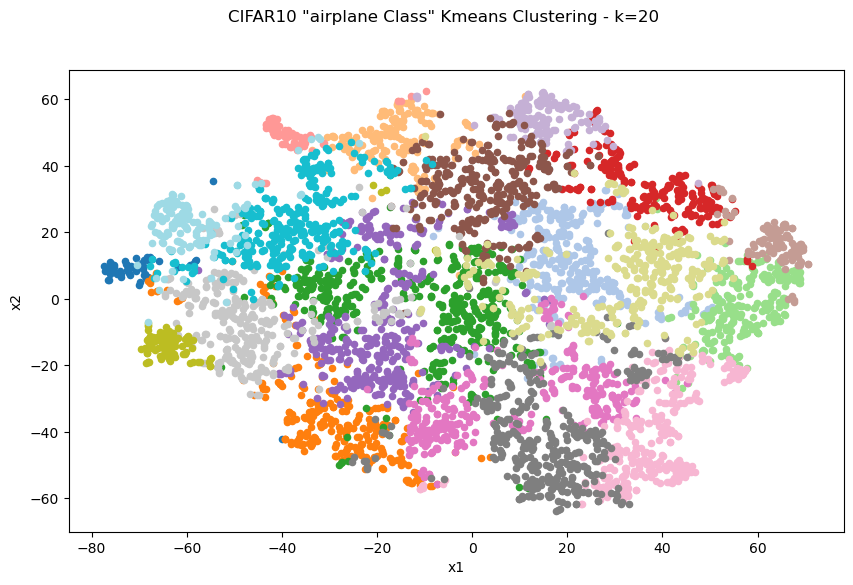

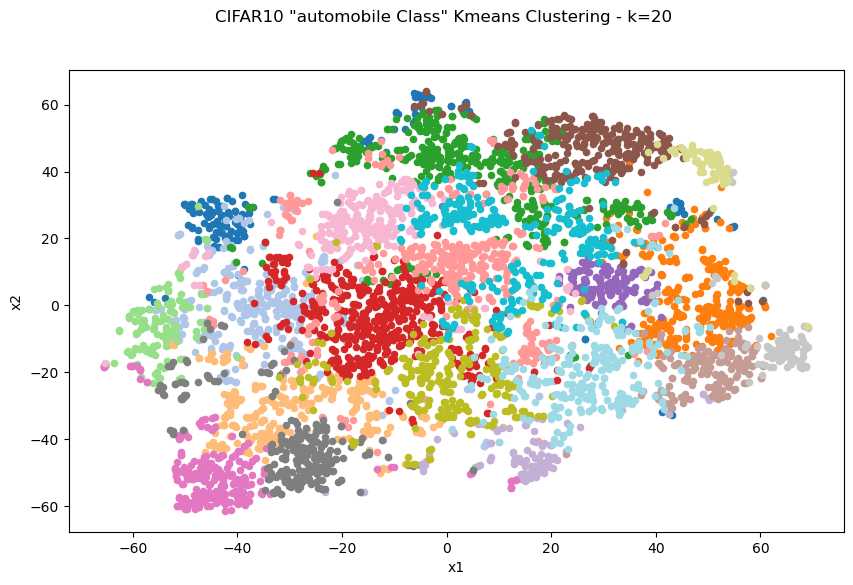

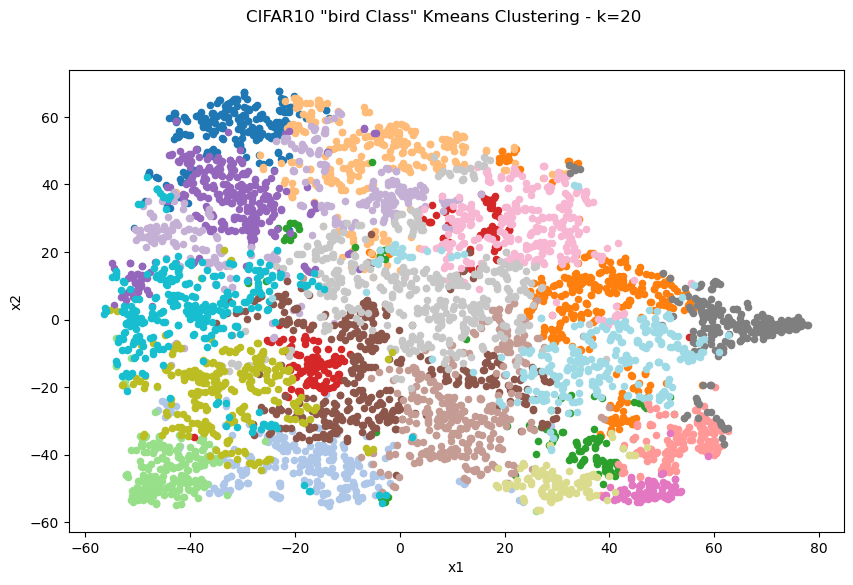

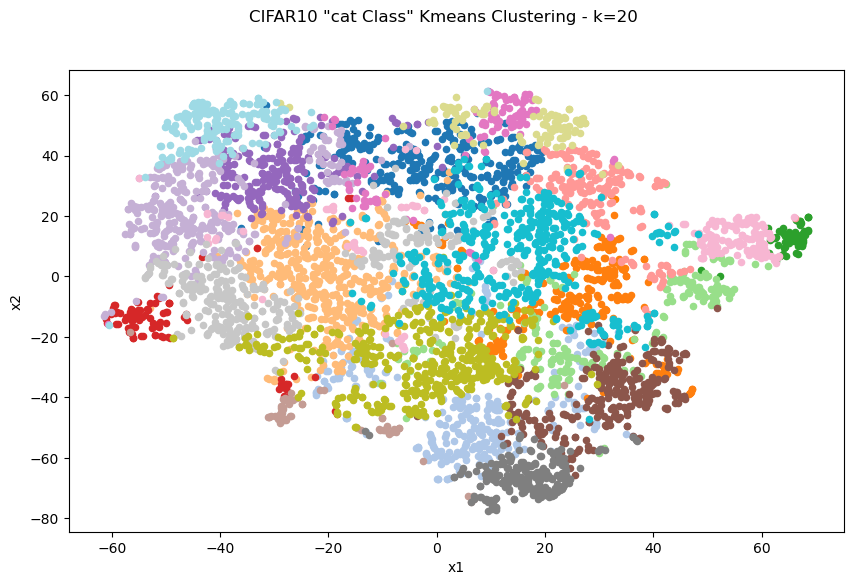

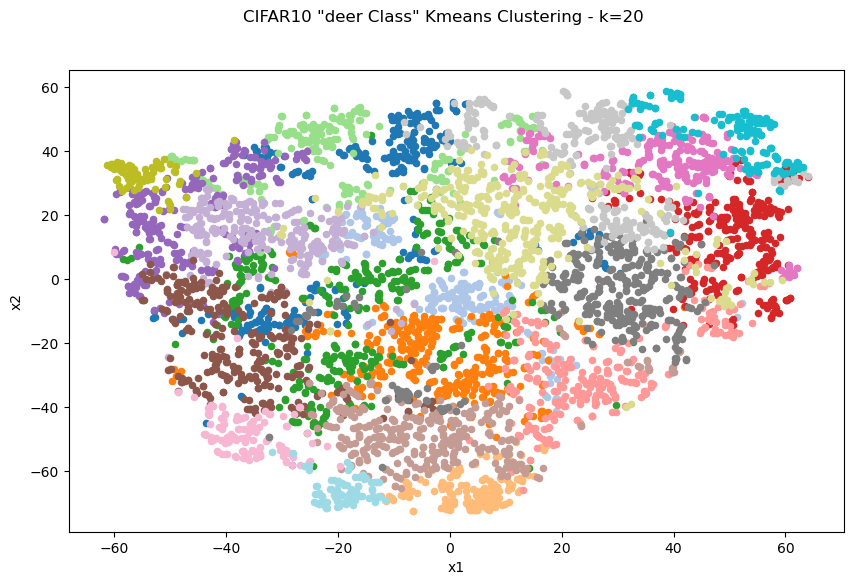

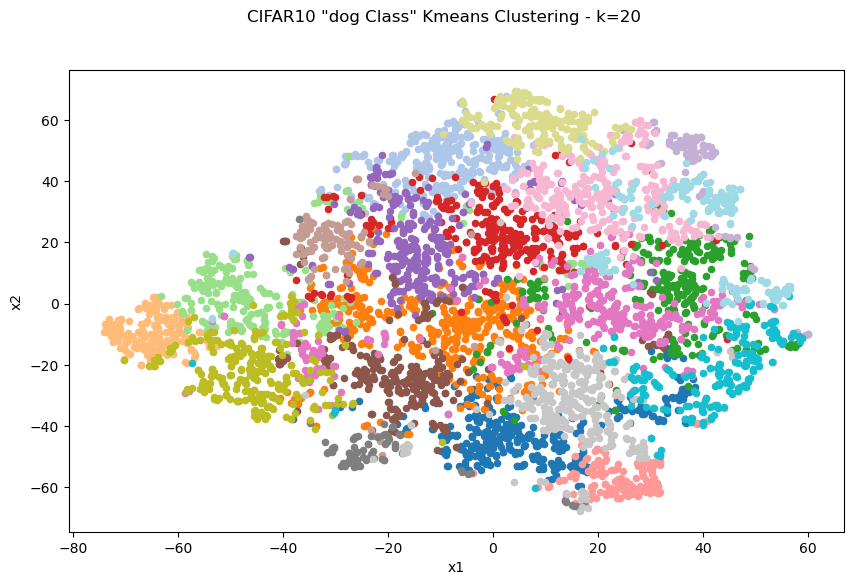

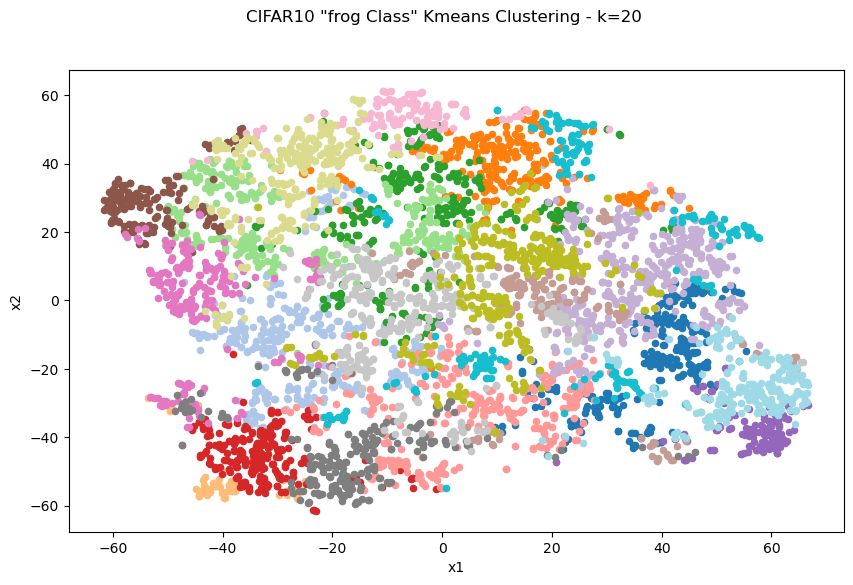

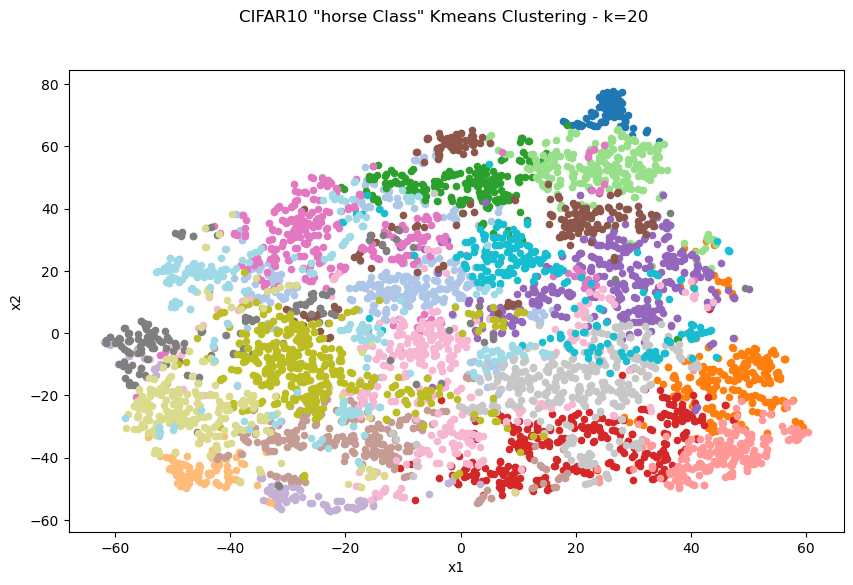

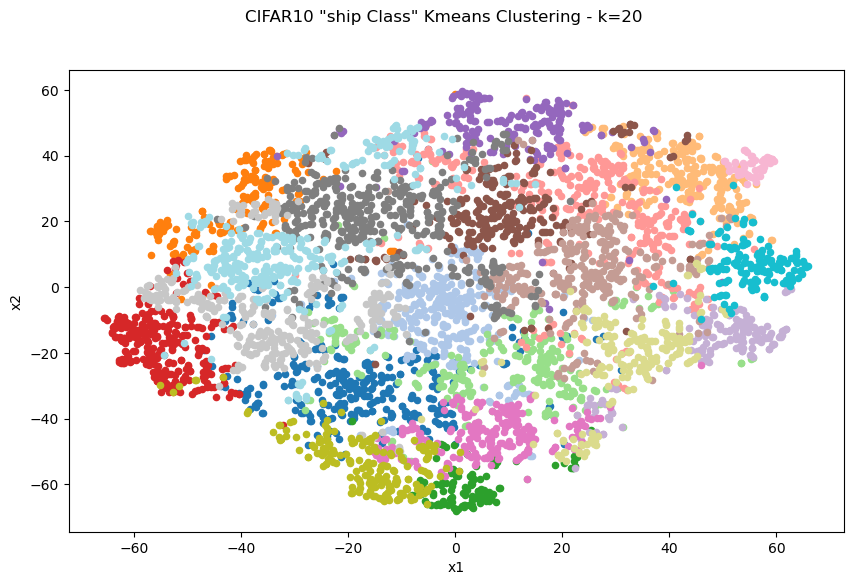

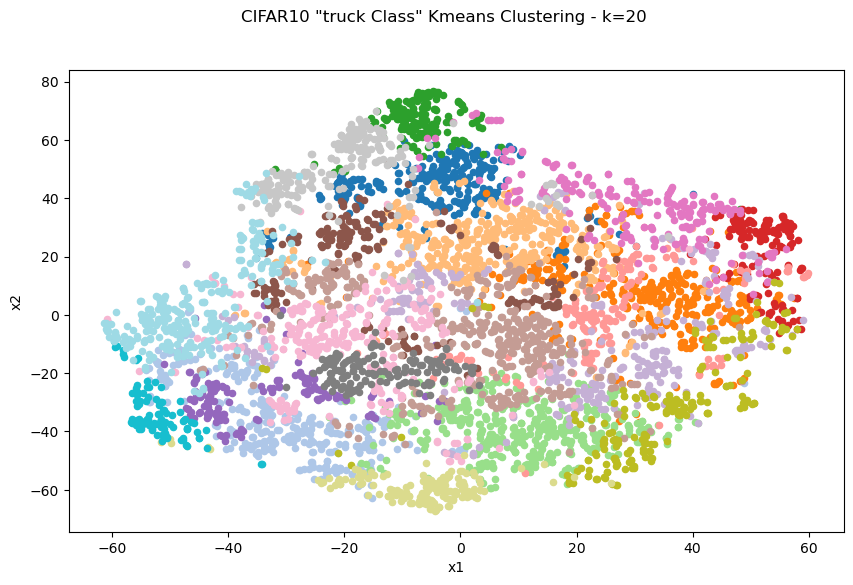

In [13]:
# K-Means
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt


layer_idx = 0
iter = 20
num_clusters = 20
indices_sub_class = {}
indices_sub_class_centers = {}
for class_idx in range(10):
    class_name = class_names[class_idx]
    batch_size = int(len(indices_class[class_idx]) / iter)
    
    features = []
    print(f"Gathering features for class {class_name}")
    for it in range(iter):
        imgs = images_all[indices_class[class_idx][it*batch_size:(it+1)*batch_size]]
        _, _feature = net(imgs)
        features.append(F.avg_pool2d(_feature[layer_idx], (_feature[layer_idx].shape[2],_feature[layer_idx].shape[3])).squeeze())
    features = torch.cat(features, dim=0).detach().cpu().numpy()
    
    print(f"Calculating cluster center features for class {class_name}")
    kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=300, random_state=1, verbose=0).fit(features)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    indices_sub_class[class_idx] = labels
    indices_sub_class_centers[class_idx] = centers
    
    feature_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30).fit_transform(np.concatenate((features, centers),axis=0))
    feature = feature_embedded[:5000, :]
    centers = feature_embedded[5000:,:]
    
    df = pd.DataFrame(dict(x1=feature[:,0], x2=feature[:,1], label=labels))

    cdict = {i:plt.cm.tab20(i) for i in range(num_clusters)}

    fig, ax = plt.subplots(figsize=(10,6))
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x1',y='x2',color=cdict[key])
    fig.suptitle(f"CIFAR10 \"{class_name} Class\" Kmeans Clustering - k={num_clusters}")
    plt.savefig(f"./results/cifar10_k{num_clusters}_{layer_idx}_{class_name}")

In [14]:
sub_class_index = {i:{} for i in range(10)}
for class_idx in range(10):
    original_index = indices_class[class_idx]
    sub_index = indices_sub_class[class_idx]
    for orig, sub in zip(original_index, sub_index):
        if sub not in sub_class_index[class_idx]:
            sub_class_index[class_idx][sub] = [orig]
        else:
            sub_class_index[class_idx][sub].append(orig)
torch.save(sub_class_index, f"sub_class_index_layer{layer_idx}.pt")

In [15]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid

vis_train = datasets.CIFAR10("./dataset", train=True, download=True, transform=transforms.ToTensor()) # no augmentation
vis_images_all = [torch.unsqueeze(vis_train[i][0], dim=0) for i in range(len(vis_train))]
vis_images_all = torch.cat(vis_images_all, dim=0)

for class_idx in range(10):
    class_name = class_names[class_idx]
    img_idx = sub_class_index[class_idx]
    grid_imgs = []
    for k in range(num_clusters):
        idxs = sub_class_index[class_idx][k]
        idx_shuffle = np.random.permutation(idxs)[:9]
        imgs = vis_images_all[idx_shuffle]
        grid_imgs.append(make_grid(imgs, nrow=3).unsqueeze(0))
    grid_imgs = torch.cat(grid_imgs, dim=0)
    final_image = make_grid(grid_imgs, nrow=5).permute(1,2,0).numpy()
    plt.imsave(f"./results/cifar10_k{num_clusters}_{layer_idx}_{class_name}_final.png", final_image)

Files already downloaded and verified
